<a href="https://colab.research.google.com/github/zloelias/hse-project-vae-lstm/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
!pip install sranodec

In [5]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sranodec import Silency
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [10]:
#df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/data/1.csv', index_col=0, header=0)
df = pd.read_csv('https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/1.csv', index_col=0, header=0)
y = df.label
X = df.drop('label', axis=1).drop('KPI ID', axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

In [17]:
class KPIDataset(Dataset):
    def __init__(self, X, y, window_len=256, sliding_step=1):
        self.start = 0
        self.window_len = window_len
        self.sliding_step = sliding_step
        self.df = X
        timeseries = ((self.df.value - self.df.value.mean()) / self.df.value.std()).values
        W = self.normality_weights(self.df.value)
        temp = []
        temp_W = []
        for i in range(self.start, len(timeseries) - self.window_len*self.sliding_step, self.sliding_step):
            temp.append(
                torch.unsqueeze(torch.tensor(timeseries[i:i+self.window_len]), 0)
            )
            temp_W.append(
                torch.unsqueeze(torch.tensor(W[i:i+self.window_len]), 0)
            )
        self.features = torch.Tensor(len(temp), self.window_len)
        self.W = torch.Tensor(len(temp_W), self.window_len)
        self.target = y
        torch.cat(temp, out=self.features)
        torch.cat(temp_W, out=self.W)
        #self.W = torch.ones(len(temp), 1, self.window_len)
        #self.W = torch.rand((len(temp), 1, self.window_len))

    def normality_weights(self, x):
        window = 1440
        saliency = Silency(window // 8, window // 8, window * 2)
        #S = np.real(saliency.transform_silency_map(x))
        #D = (S - S.mean()) / S
        #W = 1 - 1 / (1 + np.exp(-(D - 5)))
        D = saliency.generate_anomaly_score(x, type='abs')
        W = 1 - 1 / (1 + np.exp(-(D - 4)))
        return W

    def __getitem__(self, i):
        return self.features[i].unsqueeze(dim=0), self.W[i].unsqueeze(dim=0)
    
    def __len__(self):
        return len(self.features)


train_dataset = KPIDataset(X_train, y_train, window_len=256, sliding_step=1)
test_dataset = KPIDataset(X_test, y_test, window_len=256, sliding_step=1)

BATCH_SIZE = 2048
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


In [18]:
class VAE(nn.Module):
    def __init__(self, h_dim=128, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(16, 32, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(32, 64, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(64, 128, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Flatten(start_dim=1)
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (h_dim, 1)),
            nn.ConvTranspose1d(h_dim, 64, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(16, 1, kernel_size=4, stride=4),
            nn.Tanhshrink(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        #print(f'esp {esp.shape}')
        #print(f'srt {std.shape}')
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        #print(f'mu: {mu.shape}')
        #print(f'logvar: {logvar}')
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        #print(f'x {x.shape}')
        #print(f'h {h.shape}')
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar


In [26]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vae = VAE().to(device)


In [27]:
def weighted_mse_loss(input, target, weights):
        return (weights * (input - target) ** 2).mean()

def loss_fn(recon_x, x, mu, logvar, w, beta=.1):
    MSE = weighted_mse_loss(recon_x, x, w)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + beta*w.mean()*KLD, MSE, KLD

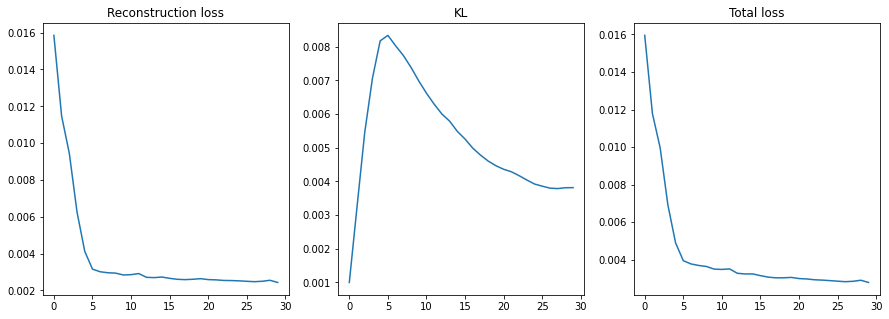

In [28]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

epochs = 30

loss_history, mse_history, kld_history = [], [], []

for epoch in range(epochs):
    total_loss, total_mse, total_kld = 0, 0, 0
    for idx, (x, w) in enumerate(train_dataloader):
        #w.to(device)
        recon_x, mu, logvar = vae(x)
        loss, mse, kld = loss_fn(recon_x, x, mu, logvar, w)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        '''
        if idx % 50 == 0:
            to_print = f"Epoch[{epoch+1}/{epochs}] Loss: {loss.item() / BATCH_SIZE} {mse.item() / BATCH_SIZE} {kld.item() / BATCH_SIZE}"
            print(to_print)
        '''
        total_loss += loss.item() / BATCH_SIZE
        total_mse += mse.item() / BATCH_SIZE
        total_kld += kld.item() / BATCH_SIZE
    
    loss_history.append(total_loss)
    mse_history.append(total_mse)
    kld_history.append(total_kld)

    fig, ax = plt.subplots(ncols=3, figsize=(15,5))

    ax[0].plot(mse_history)
    ax[0].set_title('Reconstruction loss')
    ax[1].plot(kld_history)
    ax[1].set_title('KL')
    ax[2].plot(loss_history)
    ax[2].set_title('Total loss')
    plt.show()
    plt.pause(0.3);
    clear_output(wait=True);



In [76]:
import pickle

with open('/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/vae.pcl', 'wb') as f:
    pickle.dump(vae, f)

In [29]:
temp = []
for i in tqdm(range(60000, 70000, test_dataset.window_len)):
    temp.append(torch.unsqueeze(test_dataset.features[i], 0))
    
#x = torch.Tensor(len(temp), 1, test_dataset.window_len)
x = torch.cat(temp, out=x)
x = torch.reshape(x, (len(temp), 1, test_dataset.window_len))
x_recon, mu, logvar = vae(x)

100%|██████████| 40/40 [00:00<00:00, 8039.30it/s]


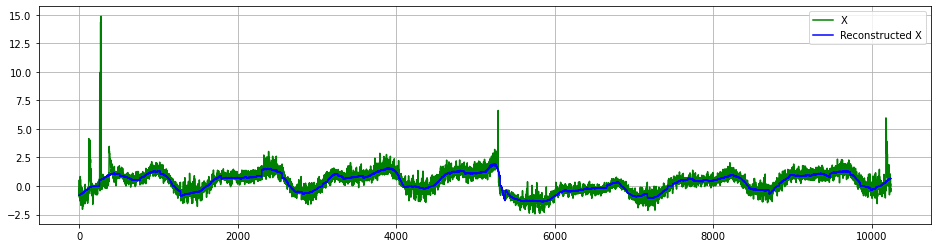

In [30]:

fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(x.reshape(-1), color='green', label='X')
ax.plot(x_recon.reshape(-1).detach(), color='blue', label='Reconstructed X')
ax.legend()

ax.grid()

#fig.savefig('/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/reconstructed.png')
plt.show()
